ランタイム > ランタイムタイプの変更 > ハードウェアアクセラレータ
から，GPUを指定してください．

Google Driveをマウントするために，下のセルを実行してURLをクリックし，出てきたコードを貼り付けてEnterを押してください．




In [1]:
import json
import os
import random

import numpy as np
import pandas as pd
import torch
import torchvision
from google.colab import drive, files
from PIL import Image
from torchvision import transforms
drive.mount('/content/drive/', force_remount=True)


Mounted at /content/drive/


Google Driveからファイルをコピーします．
初回のみ10分程度時間がかかります．


In [50]:
if not os.path.exists("/content/kueeml2020_data_2/train_input.json"):
    !rsync --progress /content/drive/MyDrive/kuee-ml-2020/kueeml2020_data_2.tar /content/ 

    # rsync: change_dir "/content/drive/MyDrive/kuee-ml-2020" failed: No such file or directory (2) が出る場合，
    # まず，データセット申請のGoogleフォームに登録したメールアドレスでログインしていることを確認してください．
    # 次に，Googleフォームに登録したメールアドレスの受信ボックスを見て，Google Driveからのメールを見て開くボタンを押してください．
    # 次に，ColabにログインしているアカウントでGoogle Driveを開き，
    # 左の「共有アイテム」を押すと「kuee-ml-2020」があることを確認してください．
    # 次に，「マイドライブ」にkuee-ml-2020へのショートカットがあるか確認してください．
    # なければ，共有アイテムから「ドライブにショートカットを追加」でマイドライブにショートカットを作成してください． 
    # そして，画面左のファイル一覧で，drive/MyDrive/kuee-ml-2020 があることを確認してください． 

    # また，2行目を下の行に置き換えるとうまくいく場合があります．
    # !rsync --progress /content/drive/MyDrive/kuee_ml_2020/kueeml2020_data.tar /content/ 
    # それでもうまく行かない場合は，どこまで確認できたかと，スクリーンショットを添えて質問メールを送ってください．2021/1/17 追記
    print("copied.")
    !tar -xvf /content/kueeml2020_data_2.tar
    print("extracted.")

ストリーミング出力は最後の 5000 行に切り捨てられました。
kueeml2020_data/kueeml2020_train/376/139376.JPG
kueeml2020_data/kueeml2020_train/376/84376.JPG
kueeml2020_data/kueeml2020_train/882/
kueeml2020_data/kueeml2020_train/882/30882.JPG
kueeml2020_data/kueeml2020_train/882/73882.JPG
kueeml2020_data/kueeml2020_train/882/53882.JPG
kueeml2020_data/kueeml2020_train/882/20882.JPG
kueeml2020_data/kueeml2020_train/882/94882.JPG
kueeml2020_data/kueeml2020_train/882/59882.JPG
kueeml2020_data/kueeml2020_train/882/44882.JPG
kueeml2020_data/kueeml2020_train/882/144882.JPG
kueeml2020_data/kueeml2020_train/882/18882.JPG
kueeml2020_data/kueeml2020_train/882/91882.JPG
kueeml2020_data/kueeml2020_train/882/115882.JPG
kueeml2020_data/kueeml2020_train/882/101882.JPG
kueeml2020_data/kueeml2020_train/882/124882.JPG
kueeml2020_data/kueeml2020_train/882/136882.JPG
kueeml2020_data/kueeml2020_train/882/65882.JPG
kueeml2020_data/kueeml2020_train/882/143882.JPG
kueeml2020_data/kueeml2020_train/403/
kueeml2020_data/kueeml2020_train/403/47

In [51]:
device = torch.device('cuda')

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
if device=='cuda':
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
def worker_init_fn(worker_id):
    random.seed(worker_id)
    np.random.seed(worker_id)


In [52]:
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
class MushroomDataset(torch.utils.data.Dataset):
    def __init__(self, json_file, root_dir, transform=None, is_train=False):
        assert os.path.exists(json_file), f"{json_file} does not exists"
        assert os.path.exists(root_dir), f"{root_dir} does not exists"
        with open(json_file) as f:
            self.annotations = json.load(f)
        self.root_dir = root_dir
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        file_path = os.path.join(self.root_dir, ann["file_path"])
        # sample = {"image": io.imread(file_path), "id": ann["id"]}
        image = Image.open(file_path)
        image_id = ann["id"]
        if self.is_train:
            label = ann["category_id"]
        else:
            label = -1
        image = self.transform(image)
        return image, image_id, label

BASE_PATH = "/content/kueeml2020_data"
TRAIN_JSON_PATH = os.path.join(BASE_PATH, "train_input.json")
TEST_JSON_PATH = os.path.join(BASE_PATH, "test_input.json")

# from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(0.9),
    transforms.RandomRotation(10),
    # transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.Normalize((0.5,),(0.5,)),
])

batch_size = 128
learning_rate = 0.001
num_classes = 100
num_epochs = 200




In [53]:
train_ds = MushroomDataset(TRAIN_JSON_PATH, BASE_PATH, is_train=True, transform=preprocess)
test_ds = MushroomDataset(TEST_JSON_PATH, BASE_PATH, is_train=False, transform=preprocess)

train_dl = torch.utils.data.DataLoader(dataset=train_ds,
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=2,
                                           worker_init_fn=worker_init_fn)
test_dl = torch.utils.data.DataLoader(dataset=test_ds,
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          num_workers=2,
                                          worker_init_fn=worker_init_fn)


In [54]:
class NeuralNet(torch.nn.Module):
    # 参考実装間違ってました．すみません． 2021/01/17 追記
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.relu = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(input_size, hidden_size) 
        self.fc12 = torch.nn.BatchNorm1d(hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)  
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)  
        self.fc4 = torch.nn.Linear(hidden_size, hidden_size)  
        self.fc5 = torch.nn.Linear(hidden_size, num_classes)  

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        out = self.fc1(x)
        out = self.fc12(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        # out = self.fc3(out)
        # out = self.relu(out)
        # out = self.fc4(out)
        # out = self.relu(out)
        out = self.fc5(out)
        return out

model = NeuralNet(28*28*3,1000, num_classes)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



In [23]:
import torch.nn as nn
class CNN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=7 * 7 * 256, out_features=num_classes)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
  

model = CNN(num_classes)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [30]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn(x)
        x += self.shortcut(identity)
        return x

class ResNet(nn.Module):
    def __init__(self, block):
        super().__init__()
        self.linear = nn.Linear(in_features=28*28*3, out_features=1000)
        self.layer = self._make_layer(block, 3, 3, 3)
    def _make_layer(self, block, num_residual_blocks, in_channels, out_channels):
        layers = []
        for i in range(num_residual_blocks):
            if i == 0:
                layers.append(block(in_channels, out_channels))
            else:
                layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.layer(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

model = ResNet(ResidualBlock)

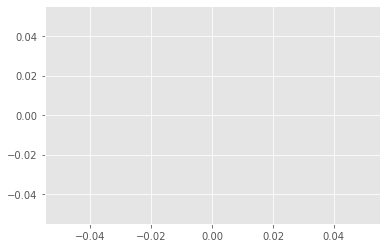

In [43]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.plot(losses)

In [17]:
images=3
image_ids=32
labels=42
i=0

In [55]:
model = model.to(device)
total_step = len(train_dl)
losses=[]
# num_epochs = 200
for epoch in range(num_epochs):
    for i, (images, image_ids, labels) in enumerate(train_dl):
        images = images.to(device)
        labels = labels.to(device)
        # optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 5 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    losses.append(loss.item())

RuntimeError: ignored

In [49]:
model.eval()
with torch.no_grad():
    submission = []
    for i, (images, image_ids, _) in enumerate(test_dl):
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for img_id, pred in zip(image_ids, predicted.cpu().detach()):
            submission.append((img_id.item(), pred.item()))

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f6cf40cc7f0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f6cf06fd0b8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

RuntimeError: ignored

In [41]:
submission_file = "/content/submission.csv"
with open(submission_file, "w") as f:
    f.write("id,predicted\n")
    for sub in submission:
        f.write(f"{sub[0]},{sub[1]}\n")


In [42]:
files.download(submission_file) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>